In [25]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC

In [26]:
# Путь к файлу в формате GFF3
gff_file_name = '/Users/nata/Documents/genome_project/Orhtonectids_project/int_linn/Intoshia_linnei_genomic.gff'

# Путь к файлу в формате Fasta
scaffolds_file_name = '/Users/nata/Documents/genome_project/Orhtonectids_project/int_linn/intoshia_linnei_Moscow.fna'

genes_sequences_out_file_name = '/Users/nata/Documents/genome_project/Orhtonectids_project/int_linn/intoshia_linnei_Moscow.fna'

In [27]:
# Считываем файл в таблицу Pandas
# в переменную с именем df
df = pd.read_table(gff_file_name, header=None, comment='#',
                   names=['label', 'source', 'kind',
                          'start', 'stop', 'score',
                          'strand', 'phase', 'attr'])
# создаем колонку с именем 'len', в которую записываем длину по формуле ниже
df['len'] = df['stop'] - df['start'] + 1

# создаем вспомогательные колонки 'ID' и 'Parent' (пока пустые)
df['ID'] = np.nan
df['Parent'] = np.nan

In [28]:
# временная таблица new для разбора атрибутов gff
new = df['attr'].str.split(';', n=1, expand=True)

# заполняем колонки 'ID' и 'Parent' полями из атрибутов
for col_i in new:
    try:
        df['ID'].fillna(new[col_i].str.split('ID=', n=1, expand=True).dropna()[1], inplace=True)
    except:
        pass
    try:
        df['Parent'].fillna(new[col_i].str.split('Parent=', n=1, expand=True).dropna()[1], inplace=True)
    except:
        pass
# дополнительные колонки 'Parent0', 'Parent1',... для иерархии наследования
new = df['Parent'].str.split('.', expand=True)
for col_i in new:
    try:
        df['Parent%d' % col_i] = new[col_i].dropna()
    except:
        pass

In [29]:
scaffolds = pd.DataFrame(df['label'].unique(), columns=['label'])
scaffolds['length'] = 0
scaffolds['seq'] = ''
# создадим пустую колонку 'coverage' для записи
# вычисленного значения покрытия генами
scaffolds['coverage'] = 0.0

records = SeqIO.parse(scaffolds_file_name, 'fasta')
for record in records:
    idx = scaffolds.index[scaffolds['label'] == record.id]
    scaffolds.loc[idx, 'seq'] = str(record.seq)
    scaffolds.loc[idx, 'length'] = len(str(record.seq))
scaffolds.sort_values('length', ascending=False, inplace=True)
scaffolds['id'] = np.arange(1, len(scaffolds['label']) + 1) 

In [30]:
gff_sequences_table = pd.merge(df, scaffolds, on='label')

def extract_location(name, start, stop):
    return(name[start-1:stop])

gff_sequences_table = gff_sequences_table.assign(location=gff_sequences_table.apply(lambda x: extract_location(x['seq'], x['start'], x['stop']), axis=1))
genes_data = gff_sequences_table.loc[gff_sequences_table['kind'] == 'gene'][['ID', 'start', 'stop','location', 'strand']].values
for_labels = genes_data[:,:3]
labels = []
for lbl_data in for_labels:
    labels.append(lbl_data[0] + '_%d_%d' % (lbl_data[1], lbl_data[2]))
records = []
for i, label in enumerate(labels):
    seq = Seq(genes_data[i, 3], IUPAC.unambiguous_dna)
    if genes_data[i, 4] == '-':
        seq = seq.reverse_complement()
    record = SeqRecord(seq, id=label, name=label, description="")
    records.append(record)
SeqIO.write(records, genes_sequences_out_file_name, 'fasta')

8724

In [31]:
# функция для подсчета структурных элементов по заданному типу (kind)
def count_kind(df, kind='intron'):
    sub = df.loc[df['kind'] == kind]
    genes = df.loc[df['kind'] == 'gene']['ID'].values
    count = np.zeros(genes.size, dtype=np.int)
    for i, gene in enumerate(genes):
        count[i] = len(sub.loc[sub['Parent0'] == gene])
    return count

In [32]:
introns_count = count_kind(df, kind='intron')

In [33]:
df

,label,source,kind,start,stop,score,strand,phase,attr,len,ID,Parent,Parent0,Parent1,Parent2,Parent3,Parent4,Parent5,Parent6
0,LWCA01002079.1,Genbank,region,1,3519,.,+,.,ID=id0;Dbxref=taxon:1819745;collection-date=15...,3519,id0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LWCA01000537.1,Genbank,region,1,25140,.,+,.,ID=id1;Dbxref=taxon:1819745;collection-date=15...,25140,id1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LWCA01000537.1,Genbank,gene,20,679,.,-,.,"ID=gene0;Name=A3Q56_04109;end_range=679,.;gbke...",660,gene0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LWCA01000537.1,Genbank,mRNA,20,679,.,-,.,"ID=rna0;Parent=gene0;end_range=679,.;gbkey=mRN...",660,rna0,"gene0;end_range=679,.;gbkey=mRNA;orig_protein_...","gene0;end_range=679,",;gbkey=mRNA;orig_protein_id=gnl|WGS:LWCA|A3Q56...,A3Q56_04109;partial=true;product=hypothetical ...,",20",NaN,NaN,NaN
4,LWCA01000537.1,Genbank,exon,502,679,.,-,.,"ID=id2;Parent=rna0;end_range=679,.;gbkey=mRNA;...",178,id2,"rna0;end_range=679,.;gbkey=mRNA;orig_protein_i...","rna0;end_range=679,",;gbkey=mRNA;orig_protein_id=gnl|WGS:LWCA|A3Q56...,A3Q56_04109;partial=true;product=hypothetical ...,NaN,NaN,NaN,NaN
5,LWCA01000537.1,Genbank,exon,20,210,.,-,.,ID=id3;Parent=rna0;gbkey=mRNA;orig_protein_id=...,191,id3,rna0;gbkey=mRNA;orig_protein_id=gnl|WGS:LWCA|A...,rna0;gbkey=mRNA;orig_protein_id=gnl|WGS:LWCA|A...,A3Q56_04109;partial=true;product=hypothetical ...,",20",NaN,NaN,NaN,NaN
6,LWCA01000537.1,Genbank,CDS,502,679,.,-,0,ID=cds0;Parent=rna0;Dbxref=NCBI_GP:OAF67967.1;...,178,cds0,rna0;Dbxref=NCBI_GP:OAF67967.1;Name=OAF67967.1...,rna0;Dbxref=NCBI_GP:OAF67967,1;Name=OAF67967,1;gbkey=CDS;orig_transcript_id=gnl|WGS:LWCA|mrna,A3Q56_04109;partial=true;product=hypothetical ...,1,NaN,NaN
7,LWCA01000537.1,Genbank,CDS,20,210,.,-,2,ID=cds0;Parent=rna0;Dbxref=NCBI_GP:OAF67967.1;...,191,cds0,rna0;Dbxref=NCBI_GP:OAF67967.1;Name=OAF67967.1...,rna0;Dbxref=NCBI_GP:OAF67967,1;Name=OAF67967,1;gbkey=CDS;orig_transcript_id=gnl|WGS:LWCA|mrna,A3Q56_04109;partial=true;product=hypothetical ...,1;start_range=,",20",NaN
8,LWCA01000537.1,Genbank,gene,1186,2627,.,+,.,"ID=gene1;Name=A3Q56_04110;end_range=2627,.;gbk...",1442,gene1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,LWCA01000537.1,Genbank,mRNA,1186,2627,.,+,.,"ID=rna1;Parent=gene1;end_range=2627,.;gbkey=mR...",1442,rna1,"gene1;end_range=2627,.;gbkey=mRNA;orig_protein...","gene1;end_range=2627,",;gbkey=mRNA;orig_protein_id=gnl|WGS:LWCA|A3Q56...,A3Q56_04110;partial=true;product=hypothetical ...,",1186",NaN,NaN,NaN


In [34]:
# получить список генов из таблицы можно так
genes = df.loc[df['kind'] == 'gene']['ID'].values

In [35]:
# посчитаем среднее число интронов на ген
print('Introns number:', np.sum(introns_count))
print('Genes number:', len(genes))
print('Average number of introns per gene:',
      np.sum(introns_count) / len(genes))

Introns number: 0
Genes number: 8724
Average number of introns per gene: 0.0


MAX at 0.0 MAX val: 8724


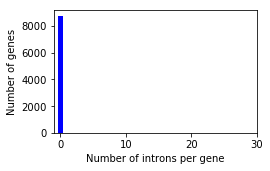

In [36]:
# задаем диапазон для гистограммы
bins_max = 30
bins_step = 1
bins = int(bins_max / bins_step)

# находим максимум
count, division = np.histogram(introns_count, bins=bins, range=(0, bins_max))
max_x = np.argmax(count)
print('MAX at', division[max_x], 'MAX val:', count[max_x])

# рисуем гистограмму
fig, ax = plt.subplots()
# если нужно изменить поля правим строку ниже
fig.subplots_adjust(left=.16, bottom=.20, right=0.97, top=0.99)

# гистограмма
ax.hist(introns_count, bins=bins, range=(0, bins_max),
        rwidth=0.7, align='left', color='blue')
ax.set_xlim(-1, bins_max)
ax.set_xlabel('Number of introns per gene')
ax.set_ylabel('Number of genes')
ax.grid(False)

# ширина и высота изображения в дюймах
width  = 3.487
height = width / 1.618  # пропорция золотого сечения
fig.set_size_inches(width, height)
# сохраняем изображение в файл
fig.savefig('Fig1.pdf')
# варианты для растровых изображений (JPG, PNG, TIFF,...)
# fig.savefig('Fig1.png', dpi=600)  # указываем разрешение dpi (точек на дюйм)

plt.show() # отрисовка картинки в Notebook

In [37]:
# задаем диапазон для гистограммы
bins_max = 600
bins_step = 10
bins = int(bins_max / bins_step)
# выберем колонку длин интронов
introns_length = df.loc[df['kind'] == 'intron']['len']
count, division = np.histogram(introns_length, bins=bins, range=(0, bins_max))
max_x = np.argmax(count)
# найдем минимальную и максимальную длину интрона
print('MAX at', division[max_x], 'MAX val:', count[max_x])
print('Average intron length:', np.average(introns_length))
print('Intron MIN length:', min(df.loc[df['kind'] == 'intron']['len']))
print('Intron MAX length:', max(df.loc[df['kind'] == 'intron']['len']))
print('Total introns number:', len(introns_length))

# рисуем гистограмму
fig, ax = plt.subplots()
# если нужно изменить поля правим строку ниже
fig.subplots_adjust(left=.19, bottom=.20, right=0.96, top=0.99)

# гистограмма
ax.hist(introns_length, bins=bins, range=(0, bins_max),
        rwidth=0.7, align='left', color='blue')
ax.set_xlim(0, bins_max)
ax.set_xlabel('Length of introns')
ax.set_ylabel('Number of introns')
ax.grid(False) #рисовать сетку на графике

# ширина и высота изображения в дюймах
width  = 3.487
height = width / 1.618  # пропорция золотого сечения
fig.set_size_inches(width, height)
# сохраняем изображение в файл
fig.savefig('Fig2.pdf')
# варианты для растровых изображений (JPG, PNG, TIFF,...)
# fig.savefig('Fig2.png', dpi=600)  # указываем разрешение dpi (точек на дюйм)

plt.show() # отрисовка картинки в Notebook

MAX at 0.0 MAX val: 0
Average intron length: nan


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: min() arg is an empty sequence

In [38]:
# Определим число интронов с длиной в указанном диапазоне
intr_max_len = 65
intr_min_len = 35
intr_cnt = len(
    df.loc[df['kind'] == 'intron']
    .loc[df['len'] <= intr_max_len]
    .loc[df['len'] >= intr_min_len])
print('Number of introns with length between',
      intr_min_len, 'and', intr_max_len, 'is',
      intr_cnt, '(%2.2f%%)' % (intr_cnt / np.sum(introns_count) * 100))
intr_cnt = len(
    df.loc[df['kind'] == 'intron']
    .loc[df['len'] < intr_min_len])
print('Number of introns with length less than',
      intr_min_len,
      intr_cnt, '(%2.2f%%)' % (intr_cnt / np.sum(introns_count) * 100))
intr_cnt = len(
    df.loc[df['kind'] == 'intron']
    .loc[df['len'] > intr_max_len])
print('Number of introns with length greater than',
      intr_max_len,
      intr_cnt, '(%2.2f%%)' % (intr_cnt / np.sum(introns_count) * 100))

Number of introns with length between 35 and 65 is 0 (nan%)
Number of introns with length less than 35 0 (nan%)
Number of introns with length greater than 65 0 (nan%)


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


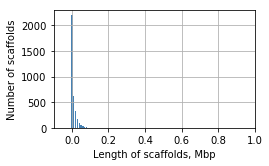

MAX at 0.0 MAX val: 2195
Min scaffold length: 488
Max scaffold length: 159981
Average scaffold length: 11819.05340909091
Total number of scaffolds: 3520
Number of scaffolds < 1 kbp: 648 (18.41%)
Number of scaffolds < 5 kbp: 1677 (47.64%)
Number of scaffolds < 10 kbp: 2195 (62.36%)
Number of scaffolds < 50 kbp: 3397 (96.51%)
Number of scaffolds > 100 kbp: 8 (0.23%)


In [39]:
# Статистика по скэффолдам
# задаем диапазон для гистограммы (в Mbp)
bins_max = 1.0
bins_step = 0.01
bins = int(bins_max / bins_step)
# рисуем гистограмму
fig, ax = plt.subplots()
# если нужно изменить поля правим строку ниже
fig.subplots_adjust(left=.16, bottom=.20, right=0.96, top=0.96)

# гистограмма
ax.hist(scaffolds['length'] / 1e6, bins=bins, range=(0, bins_max),
        rwidth=0.7, align='left', color='steelblue')
ax.set_xlim(-0.1, bins_max)
ax.set_xlabel('Length of scaffolds, Mbp')
ax.set_ylabel('Number of scaffolds')
ax.grid(True)

# ширина и высота изображения в дюймах
width  = 3.487
height = width / 1.618  # пропорция золотого сечения
fig.set_size_inches(width, height)
# сохраняем изображение в файл
fig.savefig('Fig3.pdf')
# варианты для растровых изображений (JPG, PNG, TIFF,...)
# fig.savefig('Fig3.png', dpi=600)  # указываем разрешение dpi (точек на дюйм)

plt.show() # отрисовка картинки в Notebook

count, division = np.histogram(scaffolds['length'] / 1e6, bins=bins, range=(0, bins_max))
max_x = np.argmax(count)
print('MAX at', division[max_x], 'MAX val:', count[max_x])
# найдем минимальную и максимальную длину скэффолда
print('Min scaffold length:', scaffolds['length'].min())
print('Max scaffold length:', scaffolds['length'].max())
print('Average scaffold length:', scaffolds['length'].mean())
print('Total number of scaffolds:', len(scaffolds))
print('Number of scaffolds < 1 kbp:',
      len(scaffolds.loc[scaffolds['length'] < 1e3]),
      '(%2.2f%%)' % (len(scaffolds.loc[scaffolds['length'] < 1e3]) / len(scaffolds) * 100))
print('Number of scaffolds < 5 kbp:',
      len(scaffolds.loc[scaffolds['length'] < 5e3]),
      '(%2.2f%%)' % (len(scaffolds.loc[scaffolds['length'] < 5e3]) / len(scaffolds) * 100))
print('Number of scaffolds < 10 kbp:',
      len(scaffolds.loc[scaffolds['length'] < 10e3]),
      '(%2.2f%%)' % (len(scaffolds.loc[scaffolds['length'] < 10e3]) / len(scaffolds) * 100))
print('Number of scaffolds < 50 kbp:',
      len(scaffolds.loc[scaffolds['length'] < 50e3]),
      '(%2.2f%%)' % (len(scaffolds.loc[scaffolds['length'] < 50e3]) / len(scaffolds) * 100))
print('Number of scaffolds > 100 kbp:',
      len(scaffolds.loc[scaffolds['length'] > 100e3]),
      '(%2.2f%%)' % (len(scaffolds.loc[scaffolds['length'] > 100e3]) / len(scaffolds) * 100))

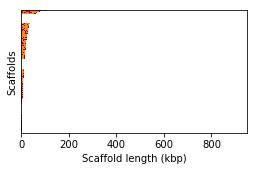

Mean coverage: 53.84%


In [40]:
# считаем покрытие скэффолдов генами
min_scaffold_length = 2000
filtered_scaffolds = scaffolds.loc[scaffolds['length'] >= min_scaffold_length]

# Единица измерения для шкалы X
scale_unit = 'kbp'
scale = {'Mbp': 1e6, 'kbp': 1e3}
max_scale = 950
# рисуем гистограмму
fig, ax = plt.subplots()
# если нужно изменить поля раскомментируем строку ниже
fig.subplots_adjust(left=.06, bottom=.20, right=0.96, top=0.99)

# Рисуем пустые скэффолды 
ax.barh(filtered_scaffolds['id'],
        filtered_scaffolds['length'] / scale[scale_unit],
        color='purple')
# Если надо, настраиваем пределы шкалы X и Y 
ax.set_xlim(0, max_scale)
ax.set_ylim(0, max(filtered_scaffolds['id'].values) + 1)
# Подписи к осям
ax.set_xlabel('Scaffold length (%s)' % scale_unit)
ax.set_ylabel('Scaffolds')

ax.set_yticks([])

# Управляем сеткой
ax.grid(False)

for scf_label in filtered_scaffolds[['id', 'label', 'length']].values:
    filtered_items = df.loc[df['kind'] == 'gene'].loc[df['label'] == scf_label[1]]
    coverage = np.sum(filtered_items['len'].values) / scf_label[2]
    idx = scaffolds.index[scaffolds['id'] == scf_label[0]]
    scaffolds.loc[idx, 'coverage'] = coverage
    ax.barh(scf_label[0],
            filtered_items['len'] / scale[scale_unit],
            left=filtered_items['start'] / scale[scale_unit],
            color='darkorange')

# Переворачиваем ось Y
ax.invert_yaxis()

# ширина и высота изображения в дюймах
width  = 3.487
height = width / 1.618  # пропорция золотого сечения
fig.set_size_inches(width, height)
# сохраняем изображение в файл
fig.savefig('Fig4.pdf')
# варианты для растровых изображений (JPG, PNG, TIFF,...)
# fig.savefig('Fig4.png', dpi=600)  # указываем разрешение dpi (точек на дюйм)

plt.show() # отрисовка картинки в Notebook

filtered_scaffolds = scaffolds.loc[scaffolds['length'] >= min_scaffold_length]
print('Mean coverage: %2.2f%%' % (filtered_scaffolds['coverage'].mean() * 100))

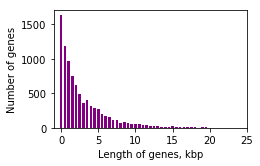

MAX at 0.0 MAX val: 1628
Min   gene length: 27
Max gene length: 45230
Average gene length: 3042.7718936267765
Total number of genes: 8724
Number of genes < 1 kbp: 2816 (32.28%)
Number of genes < 5 kbp: 7001 (80.25%)
Number of genes < 10 kbp: 8326 (95.44%)
Number of genes > 10 kbp: 397 (4.55%)


In [41]:
# Построим гистограмму размеров генов
genes = df.loc[df['kind'] == 'gene']
# задаем диапазон для гистограммы (kbp)
bins_max = 25
bins_step = 0.5
bins = int(bins_max / bins_step)
# рисуем гистограмму
fig, ax = plt.subplots()
# если нужно изменить поля правим строку ниже
fig.subplots_adjust(left=.19, bottom=.20, right=0.96, top=0.96)

# гистограмма
ax.hist(genes['len'] / 1e3, bins=bins, range=(0, bins_max),
        rwidth=0.7, align='left', color='purple')
ax.set_xlim(-1, bins_max)
ax.set_xlabel('Length of genes, kbp')
ax.set_ylabel('Number of genes')
ax.grid(False)

# ширина и высота изображения в дюймах
width  = 3.487
height = width / 1.618  # пропорция золотого сечения
fig.set_size_inches(width, height)
# сохраняем изображение в файл
fig.savefig('Fig5.pdf')
# варианты для растровых изображений (JPG, PNG, TIFF,...)
# fig.savefig('Fig5.png', dpi=600)  # указываем разрешение dpi (точек на дюйм)

plt.show() # отрисовка картинки в Notebook

count, division = np.histogram(genes['len'] / 1e3, bins=bins, range=(0, bins_max))
max_x = np.argmax(count)
print('MAX at', division[max_x], 'MAX val:', count[max_x])
# найдем минимальную и максимальную длину гена
print('Min   gene length:', genes['len'].min())
print('Max gene length:', genes['len'].max())
print('Average gene length:', genes['len'].mean())
print('Total number of genes:', len(genes))
print('Number of genes < 1 kbp:',
      len(genes.loc[genes['len'] < 1e3]),
      '(%2.2f%%)' % (len(genes.loc[genes['len'] < 1e3]) / len(genes) * 100))
print('Number of genes < 5 kbp:',
      len(genes.loc[genes['len'] < 5e3]),
      '(%2.2f%%)' % (len(genes.loc[genes['len'] < 5e3]) / len(genes) * 100))
print('Number of genes < 10 kbp:',
      len(genes.loc[genes['len'] < 10e3]),
      '(%2.2f%%)' % (len(genes.loc[genes['len'] < 10e3]) / len(genes) * 100))
print('Number of genes > 10 kbp:',
      len(genes.loc[genes['len'] > 10e3]),
      '(%2.2f%%)' % (len(genes.loc[genes['len'] > 10e3]) / len(genes) * 100))

In [42]:
# считаем плотность генов в скэффолдах
min_scaffold_length = 2000
filtered_scaffolds = scaffolds.loc[scaffolds['length'] >= min_scaffold_length]
window = 10000  #  Ширина окна сканирования(bp)
resolution = 500 # Шаг сдвига окна (bp)
Mbp_coeff = 1e6 / window
densities = []
for scf_label in filtered_scaffolds[['id', 'label', 'length']].values:
    filtered_items = df.loc[df['kind'] == 'gene'].loc[df['label'] == scf_label[1]]
    print('Scaffold %d.' % scf_label[0], 'Average genes density = %2.2f /Mbp' % (len(filtered_items) / scf_label[2] * 1e6))
    d_start = int(window / 2)
    d_steps = int((scf_label[2] - window) / resolution) + 1
    d_stop = int(d_start + resolution * (d_steps - 1))
    density = np.zeros(d_steps, dtype=np.double)
    for d_step in range(d_steps):
        window_start = int(d_start + resolution * d_step)
        density[d_step] = len(filtered_items
                              .loc[filtered_items['start'] < window_start]
                              .loc[filtered_items['stop'] > window_start]) * Mbp_coeff
        density[d_step] += len(filtered_items
                               .loc[filtered_items['start'] >= window_start]
                               .loc[filtered_items['start'] <= window_start + window]) * Mbp_coeff
    densities.append({
        'id': scf_label[0],
        'start': d_start,
        'stop': d_stop,
        'steps': d_steps,
        'resolution': resolution,
        'density': density})

Scaffold 1. Average genes density = 200.02 /Mbp
Scaffold 2. Average genes density = 224.71 /Mbp
Scaffold 3. Average genes density = 231.40 /Mbp
Scaffold 4. Average genes density = 192.02 /Mbp
Scaffold 5. Average genes density = 222.05 /Mbp
Scaffold 6. Average genes density = 203.92 /Mbp
Scaffold 7. Average genes density = 170.34 /Mbp
Scaffold 8. Average genes density = 96.57 /Mbp
Scaffold 9. Average genes density = 209.91 /Mbp
Scaffold 10. Average genes density = 147.76 /Mbp
Scaffold 11. Average genes density = 196.78 /Mbp
Scaffold 12. Average genes density = 164.55 /Mbp
Scaffold 13. Average genes density = 171.27 /Mbp
Scaffold 14. Average genes density = 240.22 /Mbp
Scaffold 15. Average genes density = 217.98 /Mbp
Scaffold 16. Average genes density = 230.16 /Mbp
Scaffold 17. Average genes density = 116.23 /Mbp
Scaffold 18. Average genes density = 242.46 /Mbp
Scaffold 19. Average genes density = 146.87 /Mbp
Scaffold 20. Average genes density = 85.81 /Mbp
Scaffold 21. Average genes dens

Scaffold 169. Average genes density = 200.74 /Mbp
Scaffold 170. Average genes density = 223.41 /Mbp
Scaffold 171. Average genes density = 89.55 /Mbp
Scaffold 172. Average genes density = 179.38 /Mbp
Scaffold 173. Average genes density = 269.12 /Mbp
Scaffold 174. Average genes density = 180.00 /Mbp
Scaffold 175. Average genes density = 225.90 /Mbp
Scaffold 176. Average genes density = 67.79 /Mbp
Scaffold 177. Average genes density = 158.24 /Mbp
Scaffold 178. Average genes density = 90.68 /Mbp
Scaffold 179. Average genes density = 45.53 /Mbp
Scaffold 180. Average genes density = 228.12 /Mbp
Scaffold 181. Average genes density = 251.72 /Mbp
Scaffold 182. Average genes density = 183.41 /Mbp
Scaffold 183. Average genes density = 252.79 /Mbp
Scaffold 184. Average genes density = 138.44 /Mbp
Scaffold 185. Average genes density = 371.24 /Mbp
Scaffold 186. Average genes density = 210.30 /Mbp
Scaffold 187. Average genes density = 210.41 /Mbp
Scaffold 188. Average genes density = 235.11 /Mbp
Scaf

Scaffold 335. Average genes density = 219.64 /Mbp
Scaffold 336. Average genes density = 94.21 /Mbp
Scaffold 337. Average genes density = 125.61 /Mbp
Scaffold 338. Average genes density = 157.54 /Mbp
Scaffold 339. Average genes density = 126.16 /Mbp
Scaffold 340. Average genes density = 221.01 /Mbp
Scaffold 341. Average genes density = 191.83 /Mbp
Scaffold 342. Average genes density = 128.16 /Mbp
Scaffold 343. Average genes density = 225.43 /Mbp
Scaffold 344. Average genes density = 225.44 /Mbp
Scaffold 345. Average genes density = 161.11 /Mbp
Scaffold 346. Average genes density = 161.25 /Mbp
Scaffold 347. Average genes density = 258.00 /Mbp
Scaffold 348. Average genes density = 322.63 /Mbp
Scaffold 349. Average genes density = 161.55 /Mbp
Scaffold 350. Average genes density = 355.56 /Mbp
Scaffold 351. Average genes density = 32.33 /Mbp
Scaffold 352. Average genes density = 96.99 /Mbp
Scaffold 353. Average genes density = 97.18 /Mbp
Scaffold 354. Average genes density = 194.79 /Mbp
Scaf

Scaffold 503. Average genes density = 158.59 /Mbp
Scaffold 504. Average genes density = 119.19 /Mbp
Scaffold 505. Average genes density = 159.01 /Mbp
Scaffold 506. Average genes density = 198.79 /Mbp
Scaffold 507. Average genes density = 278.44 /Mbp
Scaffold 508. Average genes density = 159.25 /Mbp
Scaffold 509. Average genes density = 159.28 /Mbp
Scaffold 510. Average genes density = 358.78 /Mbp
Scaffold 511. Average genes density = 239.22 /Mbp
Scaffold 512. Average genes density = 239.23 /Mbp
Scaffold 513. Average genes density = 199.70 /Mbp
Scaffold 514. Average genes density = 360.72 /Mbp
Scaffold 515. Average genes density = 160.42 /Mbp
Scaffold 516. Average genes density = 280.87 /Mbp
Scaffold 517. Average genes density = 281.02 /Mbp
Scaffold 518. Average genes density = 241.14 /Mbp
Scaffold 519. Average genes density = 201.08 /Mbp
Scaffold 520. Average genes density = 281.75 /Mbp
Scaffold 521. Average genes density = 322.26 /Mbp
Scaffold 522. Average genes density = 121.00 /Mbp


Scaffold 669. Average genes density = 143.72 /Mbp
Scaffold 670. Average genes density = 95.88 /Mbp
Scaffold 671. Average genes density = 239.79 /Mbp
Scaffold 672. Average genes density = 192.04 /Mbp
Scaffold 673. Average genes density = 192.16 /Mbp
Scaffold 674. Average genes density = 96.27 /Mbp
Scaffold 675. Average genes density = 144.57 /Mbp
Scaffold 676. Average genes density = 385.62 /Mbp
Scaffold 677. Average genes density = 48.24 /Mbp
Scaffold 678. Average genes density = 96.60 /Mbp
Scaffold 679. Average genes density = 144.94 /Mbp
Scaffold 680. Average genes density = 145.07 /Mbp
Scaffold 681. Average genes density = 145.19 /Mbp
Scaffold 682. Average genes density = 145.33 /Mbp
Scaffold 683. Average genes density = 96.99 /Mbp
Scaffold 684. Average genes density = 243.00 /Mbp
Scaffold 685. Average genes density = 194.40 /Mbp
Scaffold 686. Average genes density = 194.53 /Mbp
Scaffold 687. Average genes density = 243.19 /Mbp
Scaffold 688. Average genes density = 243.85 /Mbp
Scaff

Scaffold 835. Average genes density = 295.82 /Mbp
Scaffold 836. Average genes density = 177.55 /Mbp
Scaffold 837. Average genes density = 296.05 /Mbp
Scaffold 838. Average genes density = 177.63 /Mbp
Scaffold 839. Average genes density = 59.38 /Mbp
Scaffold 840. Average genes density = 475.17 /Mbp
Scaffold 841. Average genes density = 416.02 /Mbp
Scaffold 842. Average genes density = 178.57 /Mbp
Scaffold 843. Average genes density = 238.17 /Mbp
Scaffold 844. Average genes density = 238.31 /Mbp
Scaffold 845. Average genes density = 238.75 /Mbp
Scaffold 846. Average genes density = 238.83 /Mbp
Scaffold 847. Average genes density = 119.50 /Mbp
Scaffold 848. Average genes density = 179.71 /Mbp
Scaffold 849. Average genes density = 59.93 /Mbp
Scaffold 850. Average genes density = 179.88 /Mbp
Scaffold 851. Average genes density = 240.37 /Mbp
Scaffold 852. Average genes density = 60.16 /Mbp
Scaffold 853. Average genes density = 180.86 /Mbp
Scaffold 854. Average genes density = 120.58 /Mbp
Sca

Scaffold 1006. Average genes density = 218.82 /Mbp
Scaffold 1007. Average genes density = 219.38 /Mbp
Scaffold 1008. Average genes density = 293.75 /Mbp
Scaffold 1009. Average genes density = 293.79 /Mbp
Scaffold 1010. Average genes density = 294.42 /Mbp
Scaffold 1011. Average genes density = 221.42 /Mbp
Scaffold 1012. Average genes density = 295.29 /Mbp
Scaffold 1013. Average genes density = 221.50 /Mbp
Scaffold 1014. Average genes density = 369.30 /Mbp
Scaffold 1015. Average genes density = 369.47 /Mbp
Scaffold 1016. Average genes density = 370.04 /Mbp
Scaffold 1017. Average genes density = 148.10 /Mbp
Scaffold 1018. Average genes density = 222.39 /Mbp
Scaffold 1019. Average genes density = 299.29 /Mbp
Scaffold 1020. Average genes density = 149.85 /Mbp
Scaffold 1021. Average genes density = 149.98 /Mbp
Scaffold 1022. Average genes density = 225.11 /Mbp
Scaffold 1023. Average genes density = 375.29 /Mbp
Scaffold 1024. Average genes density = 225.36 /Mbp
Scaffold 1025. Average genes de

Scaffold 1171. Average genes density = 260.64 /Mbp
Scaffold 1172. Average genes density = 347.92 /Mbp
Scaffold 1173. Average genes density = 174.05 /Mbp
Scaffold 1174. Average genes density = 261.69 /Mbp
Scaffold 1175. Average genes density = 174.81 /Mbp
Scaffold 1176. Average genes density = 174.87 /Mbp
Scaffold 1177. Average genes density = 350.02 /Mbp
Scaffold 1178. Average genes density = 175.02 /Mbp
Scaffold 1179. Average genes density = 0.00 /Mbp
Scaffold 1180. Average genes density = 438.83 /Mbp
Scaffold 1181. Average genes density = 263.62 /Mbp
Scaffold 1182. Average genes density = 176.04 /Mbp
Scaffold 1183. Average genes density = 264.64 /Mbp
Scaffold 1184. Average genes density = 88.37 /Mbp
Scaffold 1185. Average genes density = 88.46 /Mbp
Scaffold 1186. Average genes density = 265.70 /Mbp
Scaffold 1187. Average genes density = 266.00 /Mbp
Scaffold 1188. Average genes density = 354.80 /Mbp
Scaffold 1189. Average genes density = 177.42 /Mbp
Scaffold 1190. Average genes densit

Scaffold 1338. Average genes density = 203.62 /Mbp
Scaffold 1339. Average genes density = 203.62 /Mbp
Scaffold 1340. Average genes density = 203.75 /Mbp
Scaffold 1341. Average genes density = 204.52 /Mbp
Scaffold 1342. Average genes density = 204.58 /Mbp
Scaffold 1343. Average genes density = 306.97 /Mbp
Scaffold 1344. Average genes density = 102.53 /Mbp
Scaffold 1345. Average genes density = 309.31 /Mbp
Scaffold 1346. Average genes density = 412.63 /Mbp
Scaffold 1347. Average genes density = 413.52 /Mbp
Scaffold 1348. Average genes density = 310.59 /Mbp
Scaffold 1349. Average genes density = 103.61 /Mbp
Scaffold 1350. Average genes density = 207.21 /Mbp
Scaffold 1351. Average genes density = 311.33 /Mbp
Scaffold 1352. Average genes density = 415.20 /Mbp
Scaffold 1353. Average genes density = 104.14 /Mbp
Scaffold 1354. Average genes density = 208.53 /Mbp
Scaffold 1355. Average genes density = 208.70 /Mbp
Scaffold 1356. Average genes density = 417.67 /Mbp
Scaffold 1357. Average genes de

ValueError: negative dimensions are not allowed

In [ ]:
fig, ax = plt.subplots()

# Единица измерения для шкалы X
scale_unit = 'kbp'
scale = {'Mbp': 1e6, 'kbp': 1e3}
max_scale = 150
# если нужно изменить поля правим строку ниже
fig.subplots_adjust(left=.06, bottom=.20, right=0.96, top=0.96)
hh = 0.45
gap = 1 - 2 * hh
ax.set_xlim(0, max_scale)
ax.set_ylim(0, len(densities) + 1)
# Подписи к осям
ax.set_xlabel('Scaffold length (%s)' % scale_unit)
ax.set_ylabel('Scaffolds')

ax.set_yticks([])
ax.invert_yaxis()
for i in range(len(densities)):
    #print('Average genes density = %2.2f /Mbp' % (np.average(densities[i]['density'])))
    x = np.ones((4, densities[i]['steps'])) * densities[i]['density']
    cbar = ax.imshow(x, cmap='viridis', vmin=0.0, vmax=700,
                     #aspect=1.0 / (1 * len(densities)),
                     aspect='auto',
                     alpha = 1,
                     extent=(densities[i]['start'] / scale[scale_unit],
                             densities[i]['stop'] / scale[scale_unit],
                             densities[i]['id'] - hh,
                             densities[i]['id'] + hh))
fig.colorbar(
    cbar,
    ax=ax,
    #shrink=0.75,
)

# ширина и высота изображения в дюймах
width  = 3.487
height = width / 1.618  # пропорция золотого сечения
fig.set_size_inches(width, height)
# сохраняем изображение в файл
fig.savefig('Fig6.pdf', dpi=1200)
# варианты для растровых изображений (JPG, PNG, TIFF,...)
# fig.savefig('Fig6.png', dpi=600)  # указываем разрешение dpi (точек на дюйм)

plt.show()

MAX at 90.0 MAX val: 1737
Average CDS length: 290.38878755879813
CDS MIN length: 2
CDS MAX length: 11961
Total CDS number: 31251


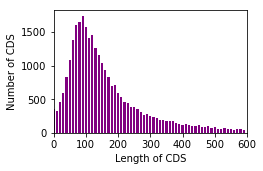

In [22]:
# задаем диапазон для гистограммы
bins_max = 600
bins_step = 10
bins = int(bins_max / bins_step)
# выберем колонку длин интронов
CDS_length = df.loc[df['kind'] == 'CDS']['len']
count, division = np.histogram(CDS_length, bins=bins, range=(0, bins_max))
max_x = np.argmax(count)
# найдем минимальную и максимальную длину интрона
print('MAX at', division[max_x], 'MAX val:', count[max_x])
print('Average CDS length:', np.average(CDS_length))
print('CDS MIN length:', min(df.loc[df['kind'] == 'CDS']['len']))
print('CDS MAX length:', max(df.loc[df['kind'] == 'CDS']['len']))
print('Total CDS number:', len(CDS_length))

# рисуем гистограмму
fig, ax = plt.subplots()
# если нужно изменить поля правим строку ниже
fig.subplots_adjust(left=.19, bottom=.20, right=0.96, top=0.99)

# гистограмма
ax.hist(CDS_length, bins=bins, range=(0, bins_max),
        rwidth=0.7, align='left', color='purple')
ax.set_xlim(0, bins_max)
ax.set_xlabel('Length of CDS')
ax.set_ylabel('Number of CDS')
ax.grid(False) #рисовать сетку на графике

# ширина и высота изображения в дюймах
width  = 3.487
height = width / 1.618  # пропорция золотого сечения
fig.set_size_inches(width, height)
# сохраняем изображение в файл
fig.savefig('Fig7.pdf')
# варианты для растровых изображений (JPG, PNG, TIFF,...)
 #fig.savefig('Fig9.png', dpi=600)  # указываем разрешение dpi (точек на дюйм)

plt.show() # отрисовка картинки в Notebook

[[  1240   2879   1639]
 [  5623   9822   4199]
 [ 13154  14257   1103]
 [ 29890  31229   1339]
 [ 40996  42458   1462]
 [ 51925  53096   1171]
 [ 60127  61269   1142]
 [ 68155  69500   1345]
 [ 74359  80146   5787]
 [115858 116912   1054]
 [138892 140802   1910]
 [143754 145242   1488]
 [149889 151739   1850]
 [166605 174824   8219]
 [178124 179160   1036]
 [224172 225997   1825]
 [238631 240082   1451]
 [251914 253378   1464]
 [255460 258529   3069]
 [265930 267133   1203]
 [278454 282355   3901]
 [294414 295562   1148]
 [302100 303315   1215]
 [314985 316844   1859]
 [326405 329860   3455]
 [393073 397259   4186]
 [404699 405734   1035]
 [447217 448413   1196]
 [466776 468260   1484]
 [471597 479736   8139]
 [493623 495173   1550]
 [531238 534578   3340]
 [543094 544926   1832]
 [553961 555006   1045]
 [564776 566148   1372]
 [569581 570803   1222]
 [575090 579896   4806]
 [581746 586062   4316]
 [615708 618560   2852]
 [627310 630325   3015]
 [651984 653243   1259]
 [662876 668265 

[[ 37208  38905   1697]
 [ 40585  43432   2847]
 [ 77402  79089   1687]
 [ 82834  83942   1108]
 [128450 129642   1192]
 [157823 161066   3243]
 [164545 165599   1054]
 [227930 229105   1175]]
[[ 10579  12069   1490]
 [ 22978  24130   1152]
 [ 35741  37071   1330]
 [ 62782  65730   2948]
 [ 69744  70811   1067]
 [ 73767  75076   1309]
 [ 84109  86188   2079]
 [108135 109436   1301]
 [115838 117163   1325]
 [146687 149533   2846]
 [159685 160933   1248]
 [199167 200359   1192]
 [204080 205234   1154]
 [211383 212835   1452]
 [223334 224474   1140]]
[[ 13166  17106   3940]
 [ 61485  62856   1371]
 [ 82040  83346   1306]
 [103967 105898   1931]
 [123654 124922   1268]
 [127984 129266   1282]
 [132961 134486   1525]
 [165190 167131   1941]
 [168264 169549   1285]
 [211072 212730   1658]
 [229742 235957   6215]]
[[ 15617  16903   1286]
 [ 25127  26759   1632]
 [ 71006  72100   1094]
 [ 77871  79421   1550]
 [ 92085  94605   2520]
 [101572 104778   3206]
 [110581 112059   1478]
 [112878 1144

[[  927  2160  1233]
 [25918 27527  1609]
 [32242 38034  5792]
 [52051 53780  1729]
 [72906 74961  2055]
 [81569 83130  1561]
 [93744 96003  2259]]
[[    0  4350  4350]
 [ 7356  9474  2118]
 [11010 12253  1243]
 [21574 22924  1350]
 [40281 42124  1843]
 [72141 73537  1396]
 [79340 80461  1121]
 [92283 93861  1578]
 [97568 98994  1426]]
[[60017 61727  1710]
 [66891 67896  1005]
 [68686 70328  1642]
 [80754 87114  6360]
 [92063 93797  1734]]
[[ 8953 11556  2603]
 [27716 33809  6093]
 [54751 55832  1081]]
[[27602 28647  1045]
 [33484 34489  1005]
 [37809 38952  1143]
 [39903 42693  2790]
 [48190 49334  1144]
 [86487 88210  1723]]
[[38152 39466  1314]
 [54309 55549  1240]
 [68127 69197  1070]
 [75434 77235  1801]]
[[13547 14821  1274]
 [21017 24415  3398]
 [31092 33249  2157]
 [51423 53041  1618]
 [60197 64059  3862]]
[[ 7592  8904  1312]
 [14317 18674  4357]
 [22319 24543  2224]
 [63649 65718  2069]
 [66186 67274  1088]]
[[ 8477  9505  1028]
 [56755 58570  1815]
 [69854 72201  2347]
 [743

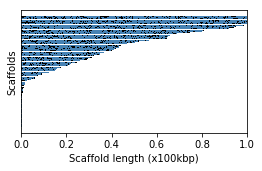

Mean coverage: 50.29%


In [23]:
# считаем пустые места скэффолдов не покрытые генами
min_scaffold_length = 500
max_gap_for_filter = 1000
filtered_scaffolds = scaffolds.loc[scaffolds['length'] >= min_scaffold_length]

# рисуем  диаграмму
fig, ax = plt.subplots()
# если нужно изменить поля раскомментируем строку ниже
fig.subplots_adjust(left=.06, bottom=.20, right=0.96, top=0.99)

# Единица измерения для шкалы X
scale_unit = 'x100kbp'
scale = {'Mbp': 1e6, 'kbp': 1e3, 'x100kbp': 0.25e6, 'x250kbp': 0.25e6}

# Рисуем пустые скэффолды 
ax.barh(filtered_scaffolds['id'],
        filtered_scaffolds['length'] / scale[scale_unit],
        color='steelblue')
# Если надо, настраиваем пределы шкалы X и Y 
ax.set_xlim(0, 1)
#ax.set_ylim(0, max(filtered_scaffolds['id'].values))
# Подписи к осям
ax.set_xlabel('Scaffold length (%s)' % scale_unit)
ax.set_ylabel('Scaffolds')

ax.set_yticks([])

# Управляем сеткой
ax.grid(False)
close_spaced_genes = []
gaps = []
for scf_label in filtered_scaffolds[['id', 'label', 'length']].values:
    sequence = filtered_scaffolds.loc[filtered_scaffolds['label'] == scf_label[1]]['seq'].values[0]
    filtered_items = df.loc[df['kind'] == 'gene'].loc[df['label'] == scf_label[1]]
    gap_starts = filtered_items['stop'].values - 1
    gap_stops = filtered_items['start'].values - 1
    if gap_stops[0] != 0:
        gap_starts = np.insert(gap_starts, 0, 0)
    else:
        gap_stops = np.delete(gap_stops, 0)
    if gap_starts[-1] != scf_label[2] - 1:
        gap_stops = np.insert(gap_stops, len(gap_stops), scf_label[2] - 1)
    else:
        gap_starts = np.delete(gap_starts, -1)
    gaps_calc = np.vstack((gap_starts, gap_stops, gap_stops - gap_starts)).T
    gaps_calc = gaps_calc[np.where(gaps_calc[:,2] > 0)]
    gaps.append(gaps_calc)
    close_spaced = np.where(gaps_calc[:,2] > max_gap_for_filter)
    if close_spaced:
        for close_id in (close_spaced[0]):
            print(gaps_calc[close_spaced])
            break
    ax.barh(scf_label[0],
            (gap_stops - gap_starts) / scale[scale_unit],
            left=gap_starts / scale[scale_unit],
            color='black')

# Переворачиваем ось Y
ax.invert_yaxis()

# ширина и высота изображения в дюймах
width  = 3.487
height = width / 1.618  # пропорция золотого сечения
fig.set_size_inches(width, height)
# сохраняем изображение в файл
fig.savefig('Fig8.pdf')
# варианты для растровых изображений (JPG, PNG, TIFF,...)
# fig.savefig('Fig7.png', dpi=600)  # указываем разрешение dpi (точек на дюйм)

plt.show() # отрисовка картинки в Notebook

print('Mean coverage: %2.2f%%' % (filtered_scaffolds['coverage'].mean() * 100))

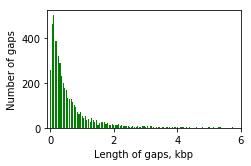

MAX at 0.1 MAX val: 502
Min gap length: 2
Max gap length: 14834
Average gap length: 620.4686046511628
gap length: 3201618


In [24]:
# Построим гистограмму пробелов
gaps_length = np.vstack(gaps)[:,2]
# задаем диапазон для гистограммы (kbp)
bins_max = 6
bins_step = 0.05
bins = int(bins_max / bins_step)
# рисуем гистограмму
fig, ax = plt.subplots()
# если нужно изменить поля правим строку ниже
fig.subplots_adjust(left=.19, bottom=.20, right=0.96, top=0.96)

# гистограмма
ax.hist(gaps_length / 1e3, bins=bins, range=(0, bins_max),
        rwidth=0.7, align='left', color='green')
ax.set_xlim(-0.1, bins_max)
ax.set_xlabel('Length of gaps, kbp')
ax.set_ylabel('Number of gaps')
ax.grid(False)

# ширина и высота изображения в дюймах
width  = 3.487
height = width / 1.618  # пропорция золотого сечения
fig.set_size_inches(width, height)
# сохраняем изображение в файл
fig.savefig('Fig9.pdf')
# варианты для растровых изображений (JPG, PNG, TIFF,...)
# fig.savefig('Fig8.png', dpi=600)  # указываем разрешение dpi (точек на дюйм)

plt.show() # отрисовка картинки в Notebook

count, division = np.histogram(gaps_length / 1e3, bins=bins, range=(0, bins_max))
max_x = np.argmax(count)
print('MAX at', division[max_x], 'MAX val:', count[max_x])
# найдем минимальную и максимальную длину ghj,tkf
print('Min gap length:', min(gaps_length))
print('Max gap length:', max(gaps_length))
print('Average gap length:', np.mean(gaps_length))
print ('gap length:', np.sum(gaps_length))

In [ ]:
filtered_scaffolds